# **Прогноз вероятности просрочки кредита заемщиком (Credit scoring)**

## **Используемые библиотеки**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.utils import class_weight

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     cross_val_score, GridSearchCV,
                                     ValidationCurveDisplay, LearningCurveDisplay)

from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             ConfusionMatrixDisplay, precision_score,
                             recall_score, precision_recall_curve)

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier, plot_importance

import optuna
import optuna.visualization as vis

warnings.filterwarnings("ignore")
np.random.seed(17)

## **Работа с данными**

### **Описание данных**

Данные представляют собой информацию о 251.503 заемщиках (https://www.kaggle.com/c/GiveMeSomeCredit).  
Задача - бинарная классификация.  
Цель - предсказать будет ли тот или иной заемщик испытывать финансовые трудности в ближайшие 2 года, т.е. будет ли просрочка по займу в течение этого срока.  
Выборка разделена на тренировочную и тестовую (150.000 объектов в тренировочной части, 101.503 объекта в тестовой).

Решение данной задачи будет ценно как кредиторам, так и заемщикам для оценки способности вернуть долг вовремя.

In [ ]:
data_train = pd.read_csv(r"..\..\credit\cs-training.csv")
data_test = pd.read_csv(r"..\..\credit\cs-test.csv")
sample_entry = pd.read_csv(r"..\..\credit\sampleEntry.csv")
features_info = pd.read_excel(r"..\..\credit\Data Dictionary.xls",
                              names=['Variable Name', 'Description', 'Type'])

In [ ]:
sample_entry

,Id,Probability
0,1,0.080807
1,2,0.040719
2,3,0.011968
3,4,0.067640
4,5,0.108264
...,...,...
101498,101499,0.045363
101499,101500,0.343775
101500,101501,0.006970
101501,101502,0.121994


In [ ]:
features_info.drop(index=0, axis=0)

,Variable Name,Description,Type
1,SeriousDlqin2yrs,Person experienced 90 days past due delinquenc...,Y/N
2,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lin...,percentage
3,age,Age of borrower in years,integer
4,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days p...,integer
5,DebtRatio,"Monthly debt payments, alimony,living costs di...",percentage
6,MonthlyIncome,Monthly income,real
7,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loa...,integer
8,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or m...,integer
9,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans inclu...,integer
10,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days p...,integer


### **Описание признаков**

1 - **SeriousDlqin2yrs** - будет ли просрочка более 90 дней в ближайшие 2 года (целевая метка) (Да/Нет)  
2 - **RevolvingUtilizationOfUnsecuredLines** - общий баланс по кредитным картам и кредитным линиям, за исключением задолженностей по недвижимости задолженности по взносам, деленные на сумму кредитных лимитов (проценты)  
3 - **age** - Возраст заемщика (в годах)  
4 - **NumberOfTime30-59DaysPastDueNotWorse** - количество просрочек в 30-59 дней (Целое)  
5 - **DebtRatio** - коэффициент задолженности, т.е. сумма ежемесячных платежей по долгам, алиментов и расходов на проживание, деленная на месячный доналоговый доход (проценты)  
6 - **Monthly Income** - месячный доход (число с плавающей точкой)  
7 - **NumberOfOpenCreditLinesAndLoans** - количество открытых кредитов и кредитных линий (Целое)  
8 - **NumberOfTimes90DaysLate** - количество просрочек более 90 дней (Целое)  
9 - **NumberRealEstateLoansOrLines** - количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии домашнего капитала (Целое)  
10 - **NumberOfTime60-89DaysPastDueNotWorse** - количество просрочек в 60-89 дней за последние 2 года (Целое)  
11 - **NumberOfDependents** - количество иждивенцев в семье (исключая самих заемщиков) (Целое)  

### **Первичный анализ данных**

Визуализируем данные в виде DataFrame, получим их размеры и удалим лишнюю информацию:

In [ ]:
print(f'Размеры тренировочной выборки: {data_train.shape}\nРазмеры тестовой выборки: {data_test.shape}')
data_train.head()

Размеры тренировочной выборки: (150000, 12)
Размеры тестовой выборки: (101503, 12)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [ ]:
data_test.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [ ]:
data_train.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
data_test.drop(columns=['Unnamed: 0', 'SeriousDlqin2yrs'], axis=1, inplace=True)
data_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [ ]:
data_test.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


Получим основную информацию о признаках и пропусках в данных:

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 1   age                                   101503 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 3   DebtRatio                             101503 non-null  float64
 4   MonthlyIncome                         81400 non-null   float64
 5   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 6   NumberOfTimes90DaysLate               101503 non-null  int64  
 7   NumberRealEstateLoansOrLines          101503 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 9   NumberOfDependents                    98877 non-null   float64
dtypes: float64(4), int64(6)
memory usage: 7.7 MB


In [ ]:
data_train.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Можем заметить, что среди признаков нет категориальных, а также, что пропуски встречаются только в признаках 'Месячный доход' и 'Количество иждивенцев'. Видимо, многие заемщики не захотели делиться этой информацией.  
Пропуски в месячном доходе заменим на среднее, а в количестве иждивенцев на 0, предполагая, что заемщики без иждивенцев сочли 0 и пропуск равнозначными ответами:

In [ ]:
data_train['NumberOfDependents'] = data_train['NumberOfDependents'].fillna(0)
data_train['MonthlyIncome'] = data_train['MonthlyIncome'].fillna(data_train['MonthlyIncome'].mean())

data_test['NumberOfDependents'] = data_test['NumberOfDependents'].fillna(0)
data_test['MonthlyIncome'] = data_test['MonthlyIncome'].fillna(data_test['MonthlyIncome'].mean())

Убедимся, что теперь в данных нет пропусков, а также оценим основные статистики по признакам:

In [ ]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,150000.0,6670.221237,12880.445756,0.0,3903.000000,6600.000000,7400.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


### **Визуализация данных**

Построим гистограммы распределения признаков, а также графики взаимосвязи всех пар признаков:

array([[<Axes: title={'center': 'SeriousDlqin2yrs'}>,
        <Axes: title={'center': 'RevolvingUtilizationOfUnsecuredLines'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'NumberOfTime30-59DaysPastDueNotWorse'}>,
        <Axes: title={'center': 'DebtRatio'}>,
        <Axes: title={'center': 'MonthlyIncome'}>],
       [<Axes: title={'center': 'NumberOfOpenCreditLinesAndLoans'}>,
        <Axes: title={'center': 'NumberOfTimes90DaysLate'}>,
        <Axes: title={'center': 'NumberRealEstateLoansOrLines'}>],
       [<Axes: title={'center': 'NumberOfTime60-89DaysPastDueNotWorse'}>,
        <Axes: title={'center': 'NumberOfDependents'}>, <Axes: >]],
      dtype=object)

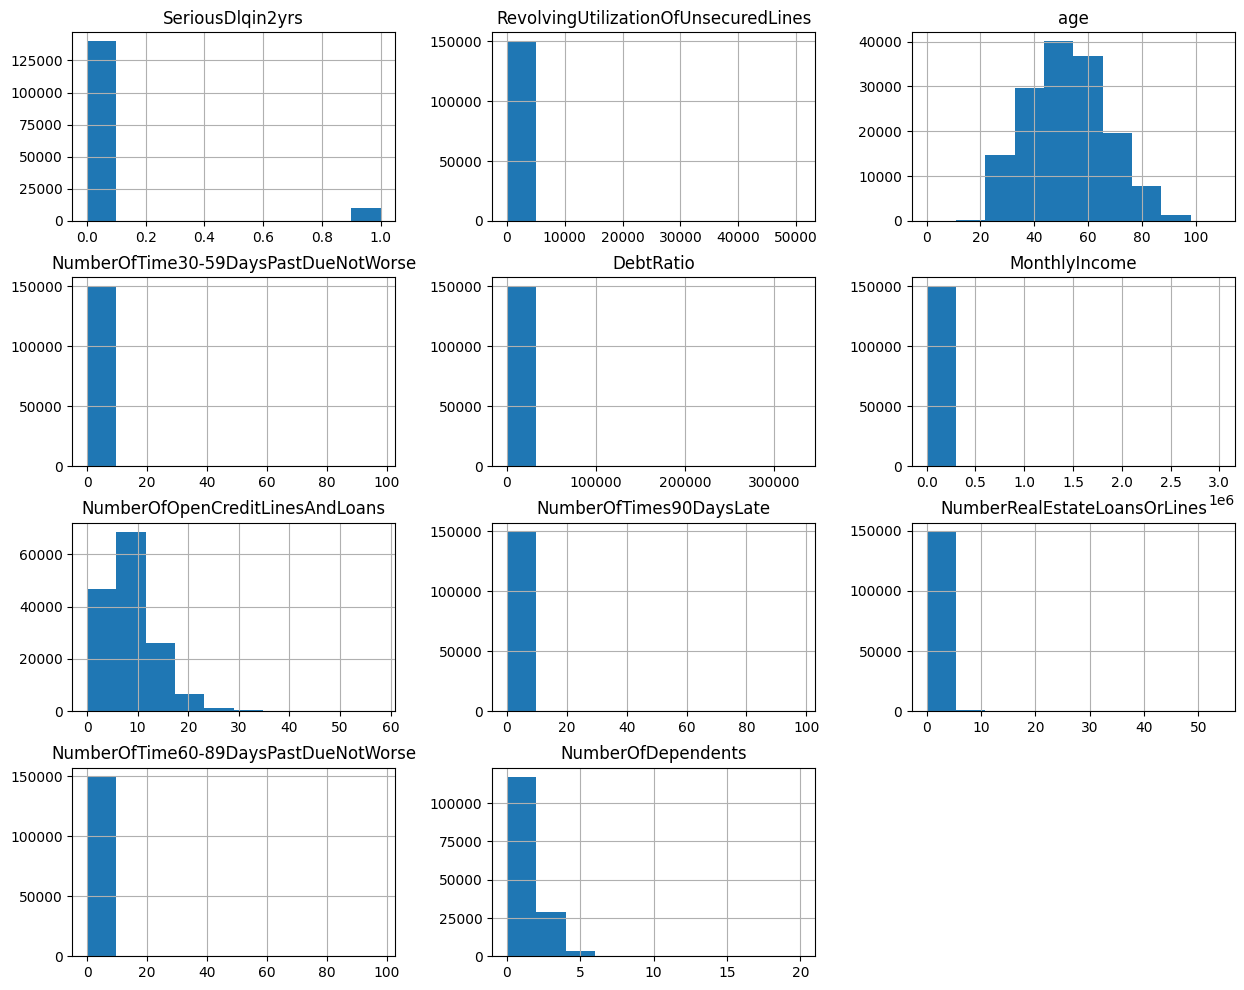

In [ ]:
data_train.hist(figsize=(15, 12))

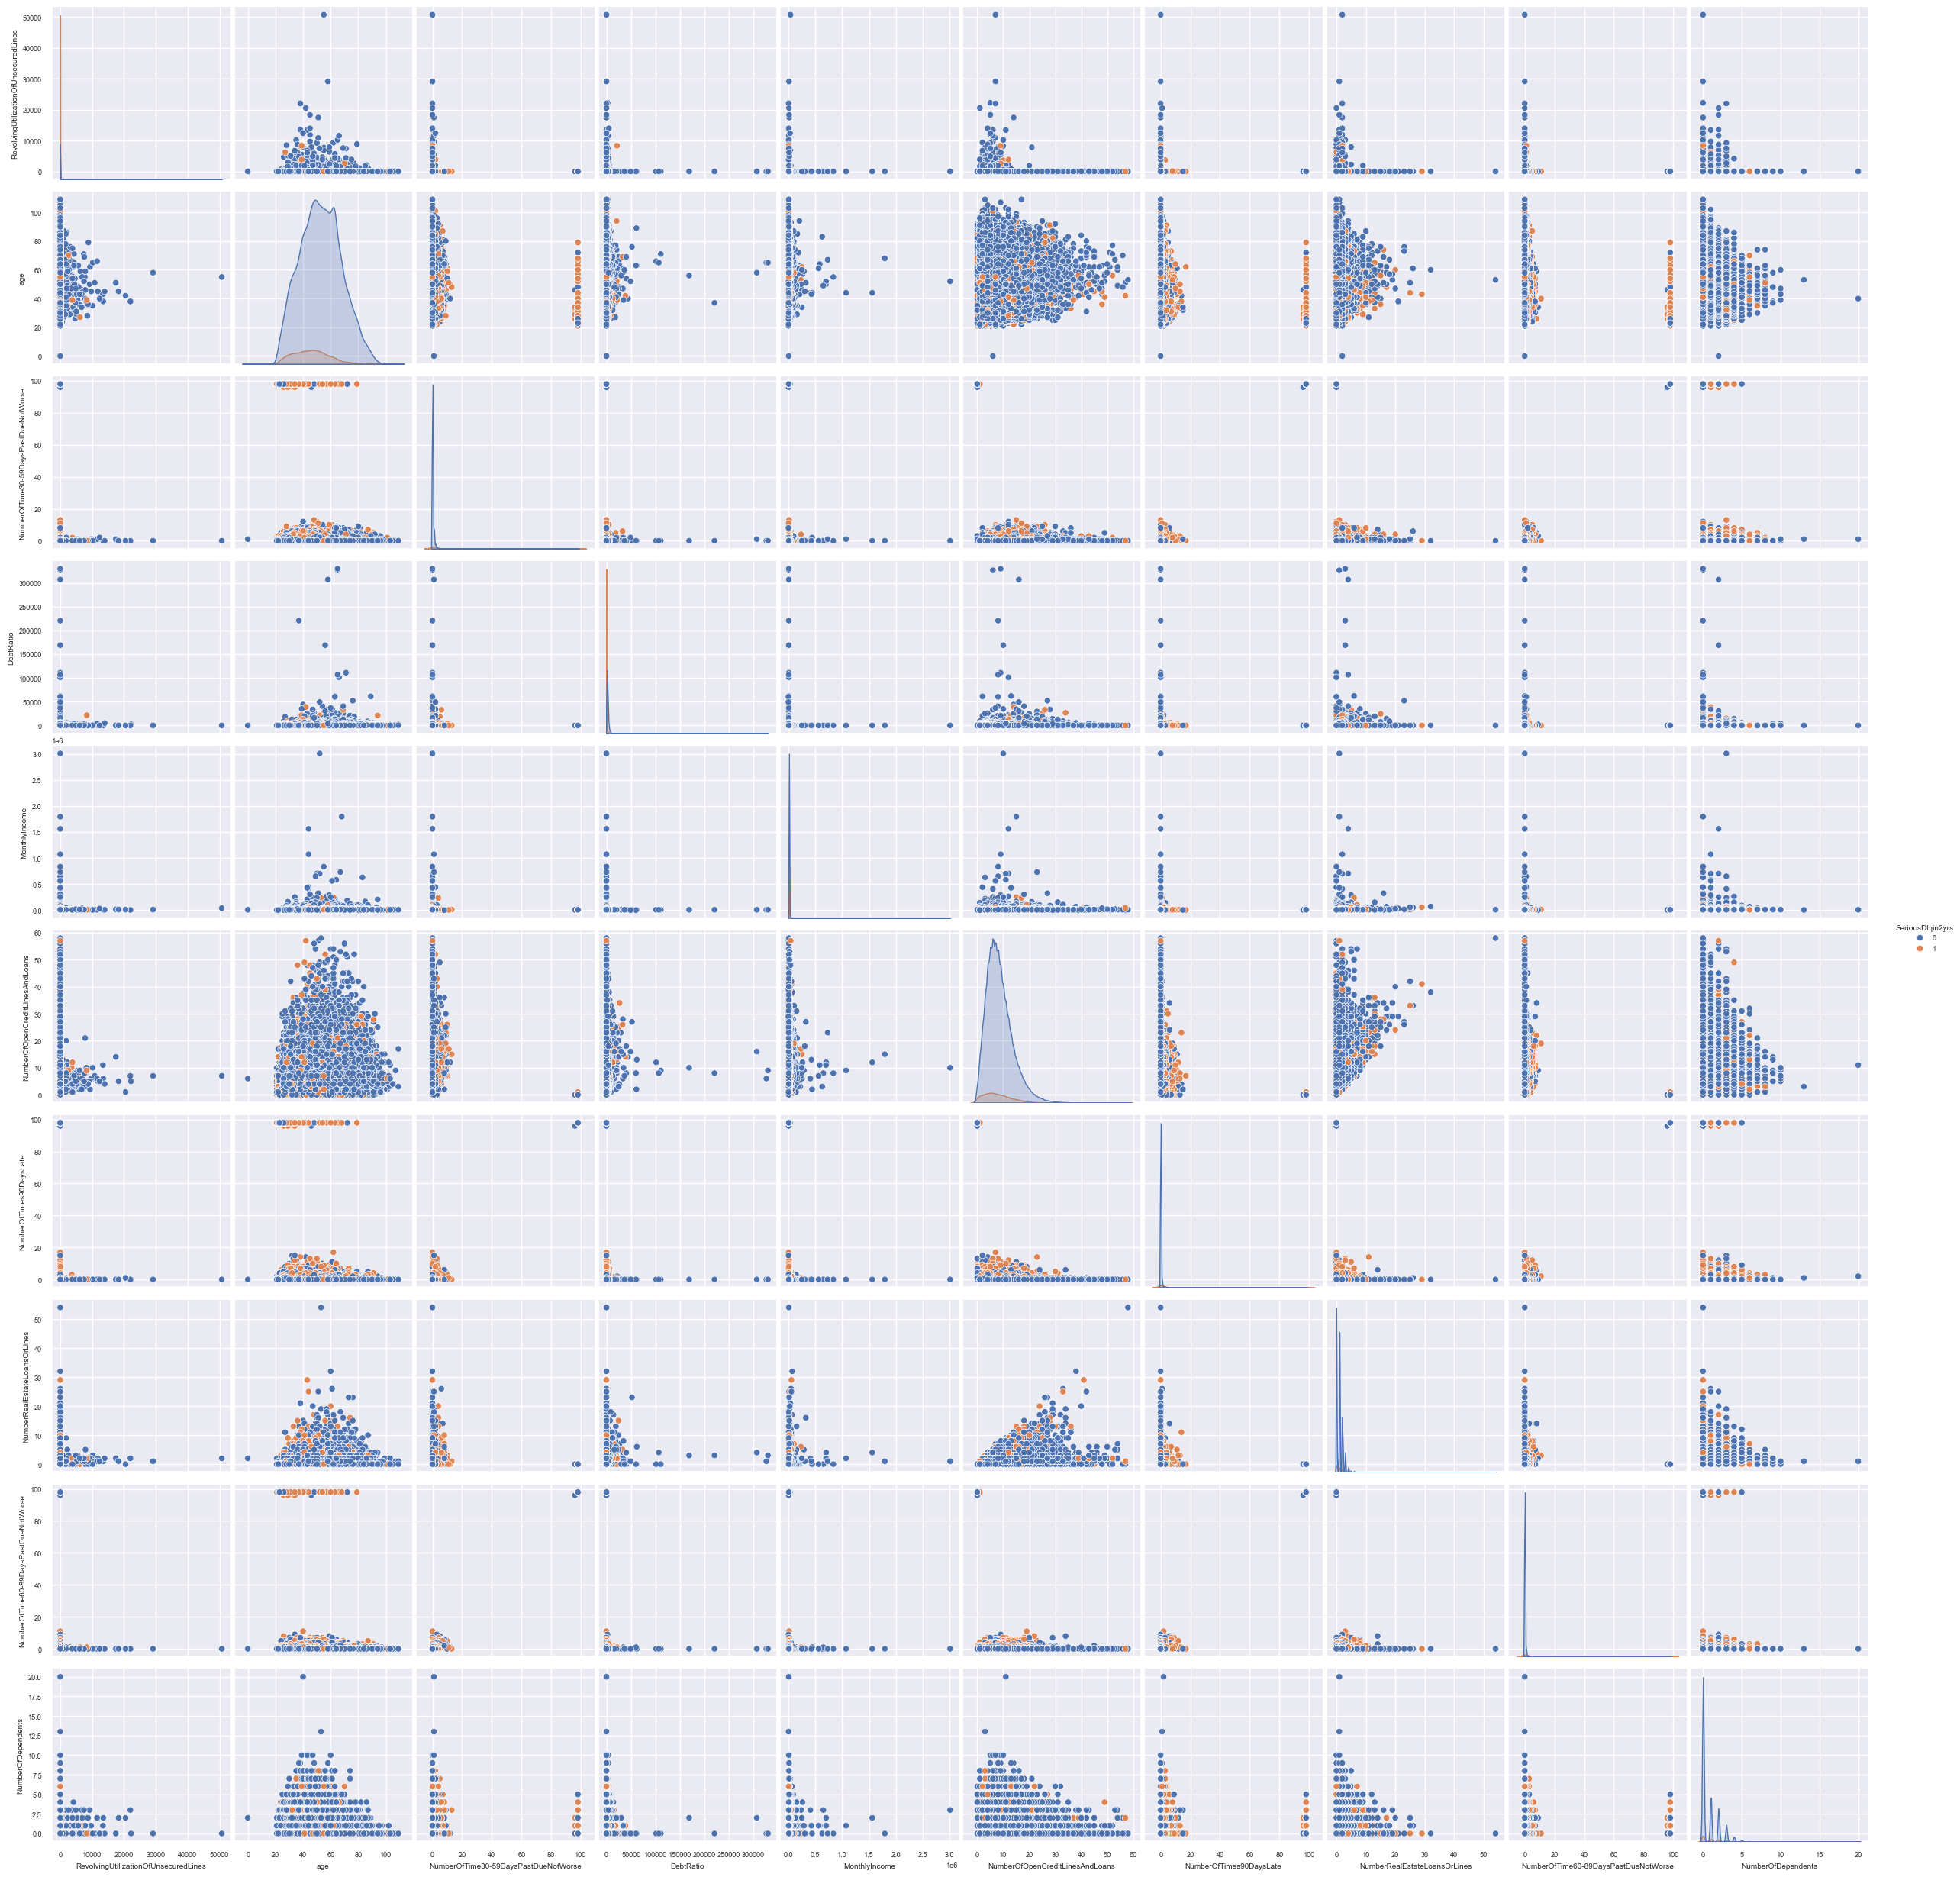

In [ ]:
sns.pairplot(data_train, hue='SeriousDlqin2yrs')

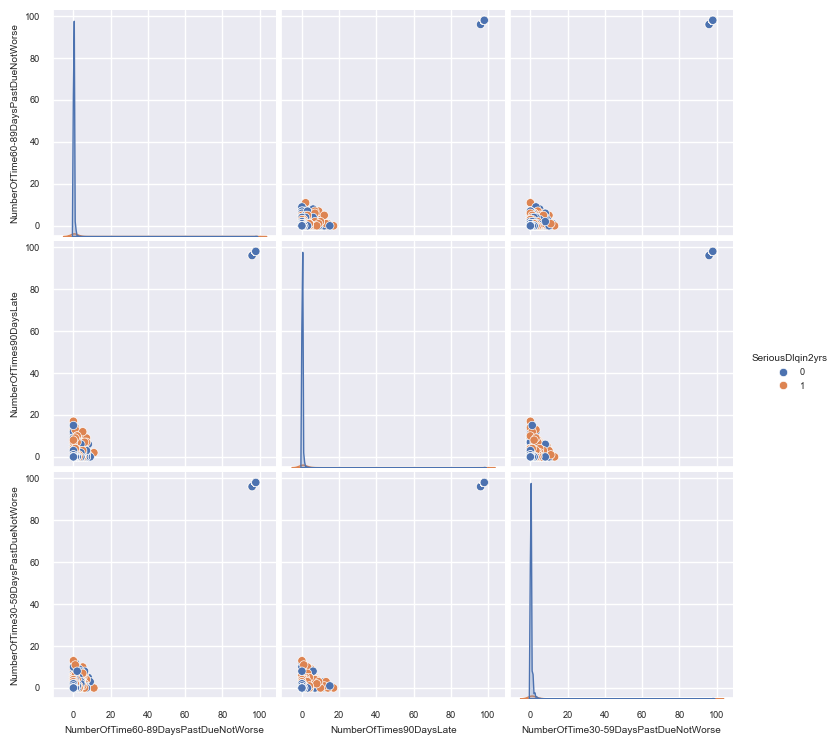

In [ ]:
sns.set_theme(font_scale=0.6)
sns.pairplot(data_train[['SeriousDlqin2yrs', 'NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate',
                   'NumberOfTime30-59DaysPastDueNotWorse']], hue='SeriousDlqin2yrs')

По графикам можем сделать вывод, что в данных присутствуют выбросы. Также среди графиков парных зависимостей признаков можно заметить схожие распределения (Признаки **NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse**).  

Посмотрим попарные корреляции признаков, а также отдельно корреляции признаков с целевой переменной:

In [ ]:
corr = data_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.001802,-0.115386,0.125587,-0.007602,-0.018002,-0.029669,0.117175,-0.007038,0.102261,0.046869
RevolvingUtilizationOfUnsecuredLines,-0.001802,1.000000,-0.005898,-0.001314,0.003961,0.006565,-0.011281,-0.001061,0.006235,-0.001048,0.001193
age,-0.115386,-0.005898,1.000000,-0.062995,0.024188,0.032984,0.147705,-0.061005,0.033150,-0.057159,-0.215693
NumberOfTime30-59DaysPastDueNotWorse,0.125587,-0.001314,-0.062995,1.000000,-0.006542,-0.007636,-0.055312,0.983603,-0.030565,0.987005,-0.004590
DebtRatio,-0.007602,0.003961,0.024188,-0.006542,1.000000,-0.005355,0.049565,-0.008320,0.120046,-0.007533,-0.044476
MonthlyIncome,-0.018002,0.006565,0.032984,-0.007636,-0.005355,1.000000,0.082319,-0.009484,0.113823,-0.008259,0.058192
NumberOfOpenCreditLinesAndLoans,-0.029669,-0.011281,0.147705,-0.055312,0.049565,0.082319,1.000000,-0.079984,0.433959,-0.071077,0.074026
NumberOfTimes90DaysLate,0.117175,-0.001061,-0.061005,0.983603,-0.008320,-0.009484,-0.079984,1.000000,-0.045205,0.992796,-0.011962
NumberRealEstateLoansOrLines,-0.007038,0.006235,0.033150,-0.030565,0.120046,0.113823,0.433959,-0.045205,1.000000,-0.039722,0.129399
NumberOfTime60-89DaysPastDueNotWorse,0.102261,-0.001048,-0.057159,0.987005,-0.007533,-0.008259,-0.071077,0.992796,-0.039722,1.000000,-0.012678


In [ ]:
data_train.corrwith(data_train['SeriousDlqin2yrs'])

,0
SeriousDlqin2yrs,1.000000
RevolvingUtilizationOfUnsecuredLines,-0.001802
age,-0.115386
NumberOfTime30-59DaysPastDueNotWorse,0.125587
DebtRatio,-0.007602
MonthlyIncome,-0.018002
NumberOfOpenCreditLinesAndLoans,-0.029669
NumberOfTimes90DaysLate,0.117175
NumberRealEstateLoansOrLines,-0.007038
NumberOfTime60-89DaysPastDueNotWorse,0.102261


In [ ]:
corr = data_train[['SeriousDlqin2yrs',
                  'NumberOfTime30-59DaysPastDueNotWorse',
                  'NumberOfTime60-89DaysPastDueNotWorse',
                  'NumberOfTimes90DaysLate']].corr()
corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate
SeriousDlqin2yrs,1.000000,0.125587,0.102261,0.117175
NumberOfTime30-59DaysPastDueNotWorse,0.125587,1.000000,0.987005,0.983603
NumberOfTime60-89DaysPastDueNotWorse,0.102261,0.987005,1.000000,0.992796
NumberOfTimes90DaysLate,0.117175,0.983603,0.992796,1.000000


Указанные выше признаки очень сильно коррелированы между собой, а также сильно коррелируют с целевой переменной.

## **Подготовка данных**

1 - Оценим дисбаланс классов,    
2 - Разделим выборку на обучающие данные и ответы,  
3 - Рассчитаем веса классов для их сбалансированности,  
4 - Нормализуем данные,  
5 - Поделим выборку на тренировочную и валидационную,  
6 - Зададим стратегию кросс-валидации.

In [ ]:
data_train['SeriousDlqin2yrs'].value_counts()

SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64

In [ ]:
X = data_train.drop(columns='SeriousDlqin2yrs').values
y = data_train['SeriousDlqin2yrs'].values

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3,
                                                  shuffle=True, stratify=y)
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [ ]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f'Коэффициент, уравнивающий классы - {scale_pos_weight}')

Коэффициент, уравнивающий классы - 13.961527500712453


## **Обучение моделей**

### **Логистическая регрессия**

Обучим логистическую регрессию, затем произведем подбор параметров и получим значение целевой метрики ROC-AUC:

In [ ]:
logit = LogisticRegression(class_weight="balanced")
scores_logit_cv = cross_val_score(logit, X_train, y_train,
                                  cv=cv, scoring='roc_auc')

print(f'Значения метрики модели на кросс-валидации: {scores_logit_cv } \nСреднее значение: {np.mean(scores_logit_cv )}')

Значения метрики модели на кросс-валидации: [0.78720789 0.79659226 0.79351653 0.78636048 0.80114223] 
Среднее значение: 0.7929638787279993


In [ ]:
logit.fit(X_train, y_train)
y_pred_logit = logit.predict_proba(X_val)[:, 1]
score_logit = roc_auc_score(y_val, y_pred_logit)
print(f'Значения метрики модели на валидационной выборке: {score_logit}')

Значения метрики модели на валидационной выборке: 0.7985953322732698


In [ ]:
params_logit = {'C': np.logspace(-2, 3, 10)}
logit_cv = GridSearchCV(logit, param_grid=params_logit, cv=cv,
                        scoring='roc_auc', verbose=3, n_jobs=8)
logit_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
logit_cv = LogisticRegression(**logit_cv.best_params_, class_weight="balanced")
logit_cv.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,np.float64(1000.0)
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [ ]:
y_pred_logit_cv = logit_cv.predict_proba(X_val)[:, 1]
best_score_logit = roc_auc_score(y_val, y_pred_logit_cv)
print(f'Лучший коэффициент регуляризации: {logit_cv.best_params_}')
print(f'Значения метрики модели на валидационной выборке: {best_score_logit}')

Лучший коэффициент регуляризации: {'C': np.float64(1000.0)}
Значения метрики модели на валидационной выборке: 0.7986295412335379


Получим матрицу ошибок:

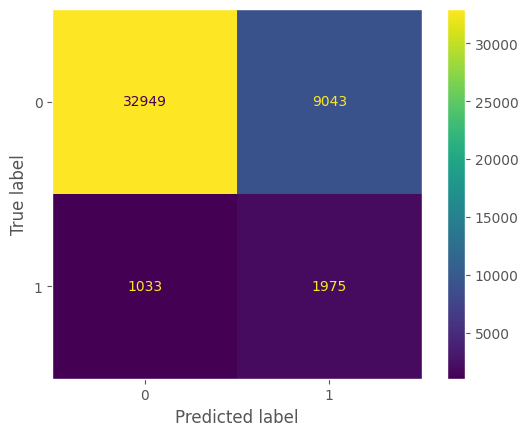

Precision: 0.179
Recall: 0.657


In [ ]:
y_pred_logit_cv_binary =  logit_cv.predict(X_val)
cm_logit = confusion_matrix(y_val, y_pred_logit_cv_binary, labels=logit_cv.classes_)
disp_logit = ConfusionMatrixDisplay(confusion_matrix=cm_logit,
                              display_labels=logit_cv.classes_)
disp_logit.plot()
plt.grid(False)
plt.show()

print(f"Precision: {np.round(precision_score(y_val, y_pred_logit_cv_binary), 3)}\nRecall: {np.round(recall_score(y_val, y_pred_logit_cv_binary), 3)}")

По матрице ошибок можем сделать вывод, что Precision ~ 0.18, а Recall ~ 0.66. В целом модель менее склонна к пропускам, что полезно для нашей задачи, но тем не менее сами метрики слишком малы.  
Визуализируем ROC-curve:

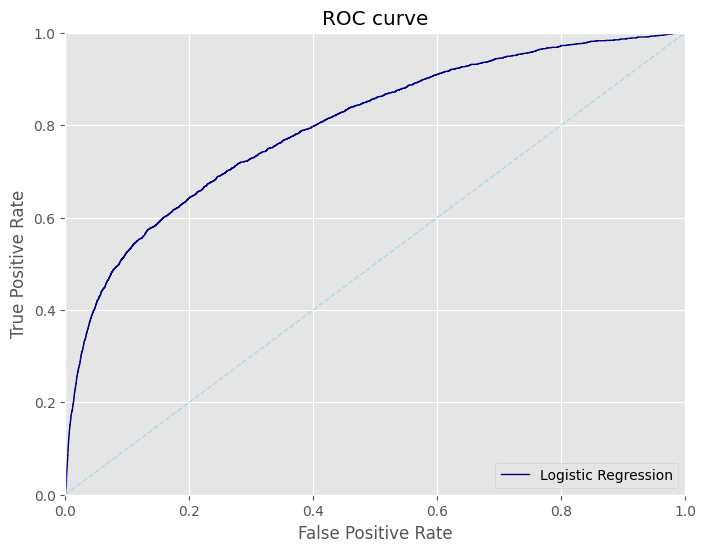

In [ ]:
fpr_1, tpr_1, _ = roc_curve(y_val, y_pred_logit_cv)

plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, color='navy', lw=1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], color='lightblue', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Отобразим валидационную кривую и кривую обучения модели:

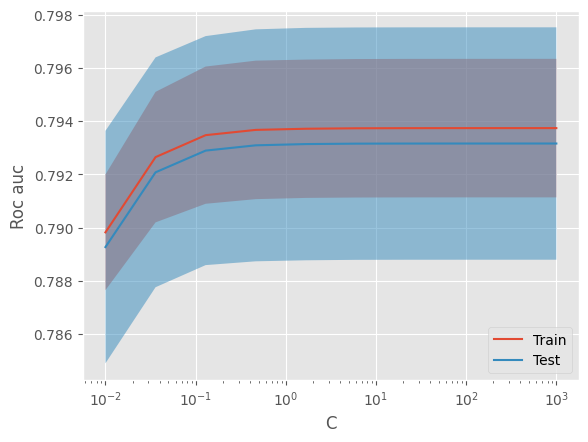

In [ ]:
ValidationCurveDisplay.from_estimator(logit_cv, X_train, y_train,
                                      param_name="C",
                                      param_range=np.logspace(-2, 3, 10),
                                      cv=cv, scoring='roc_auc',
                                      n_jobs=8)

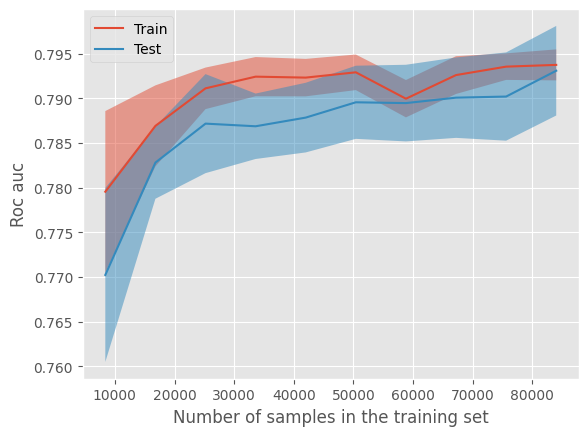

In [ ]:
LearningCurveDisplay.from_estimator(logit_cv, X_train, y_train,
                                    train_sizes=np.arange(0.1, 1.1, 0.1),
                                    cv=cv, scoring='roc_auc',
                                    n_jobs=8)

По валидационной кривой видно, что значения метрик вышли на плато на относительно невысоком значении, а значит, лучшего результата можно добиться используя более сложную модель.  

Кривая обучения показывает, что кривые на обучающей и тестовой выборках сошлись, из чего можно сделать вывод, что добавление большего количества данных не сильно повлияет на качество. Также кривая обучающей выборки лежит достаточно низко, что говорит о неспособности модели в достаточной мере отобразить закономерности в данных из-за своей простоты.  

Перейдем к более сложной модели случайного леса:

###**Случайный лес**

Проведем аналогичные действия с алгоритмом случайного леса:

In [ ]:
rf = RandomForestClassifier(n_jobs=8, class_weight='balanced')
scores_rf_cv = cross_val_score(rf, X_train, y_train, cv=cv,
                               scoring='roc_auc', n_jobs=8)

print(f'Значения метрики модели на кросс-валидации: {scores_rf_cv} \nСреднее значение: {np.mean(scores_rf_cv)}')

Значения метрики модели на кросс-валидации: [0.82186354 0.83977932 0.83119391 0.83117428 0.83061251] 
Среднее значение: 0.8309247131709288


In [ ]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_val)[:, 1]
score_rf = roc_auc_score(y_val, y_pred_rf)
print(f'Значения метрики модели на валидационной выборке: {score_rf}')

Значения метрики модели на валидационной выборке: 0.8432462708829037


In [ ]:
def objective_rf(trial):
    params_rf = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 40),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20)
    }

    model_rf = RandomForestClassifier(**params_rf, class_weight='balanced')

    score_rf = cross_val_score(model_rf, X_train, y_train, cv=cv,
                                scoring='roc_auc', n_jobs=8).mean()
    return score_rf

study_rf = optuna.create_study(study_name="rf_scoring_study", direction='maximize')
study_rf.optimize(objective_rf, n_trials=100, show_progress_bar=False, n_jobs=8)

[I 2025-12-20 14:57:46,401] A new study created in memory with name: rf_scoring_study
[I 2025-12-20 14:59:42,700] Trial 7 finished with value: 0.8495153270535871 and parameters: {'n_estimators': 143, 'max_depth': 28, 'min_samples_leaf': 1, 'min_samples_split': 18}. Best is trial 7 with value: 0.8495153270535871.
[I 2025-12-20 15:00:28,340] Trial 6 finished with value: 0.8592682786090775 and parameters: {'n_estimators': 259, 'max_depth': 35, 'min_samples_leaf': 18, 'min_samples_split': 8}. Best is trial 6 with value: 0.8592682786090775.
[I 2025-12-20 15:00:39,966] Trial 0 finished with value: 0.8570759306374743 and parameters: {'n_estimators': 201, 'max_depth': 26, 'min_samples_leaf': 13, 'min_samples_split': 8}. Best is trial 6 with value: 0.8592682786090775.
[I 2025-12-20 15:00:52,315] Trial 2 finished with value: 0.8544936747894827 and parameters: {'n_estimators': 132, 'max_depth': 18, 'min_samples_leaf': 3, 'min_samples_split': 19}. Best is trial 6 with value: 0.8592682786090775.
[I

Дополнительно выведем график важности гиперпараметров и историю их подбора:

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

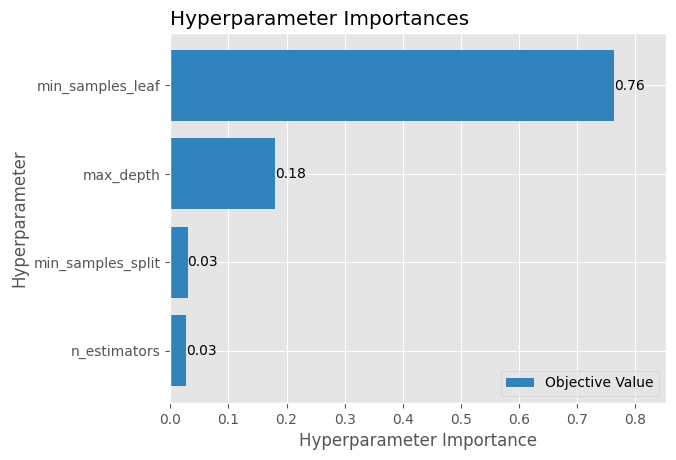

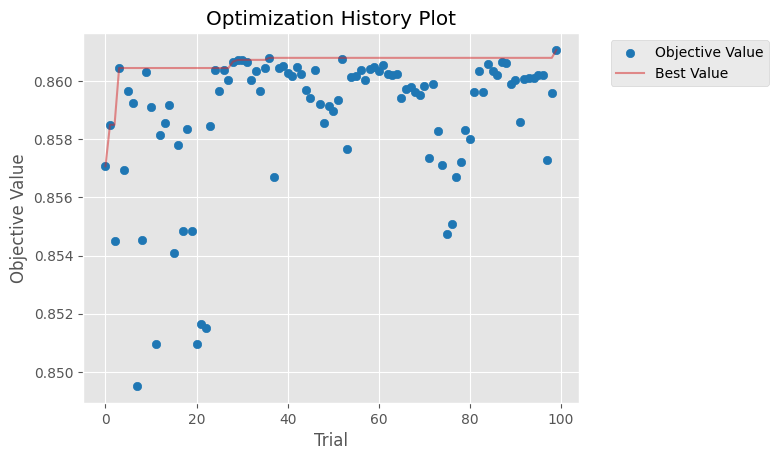

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study_rf)
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

In [ ]:
rf_cv = RandomForestClassifier(**study_rf.best_params, class_weight='balanced', n_jobs=8)
rf_cv.fit(X_train, y_train)

,n_estimators,384
,criterion,'gini'
,max_depth,11
,min_samples_split,6
,min_samples_leaf,18
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred_rf_cv = rf_cv.predict_proba(X_val)[:, 1]
best_score_rf = roc_auc_score(y_val, y_pred_rf_cv)
print(f'Лучшие параметры: {study_rf.best_params}')
print(f'Значения метрики модели на валидационной выборке: {best_score_rf}')

Лучшие параметры: {'n_estimators': 384, 'max_depth': 11, 'min_samples_leaf': 18, 'min_samples_split': 6}
Значения метрики модели на валидационной выборке: 0.8677370125971311


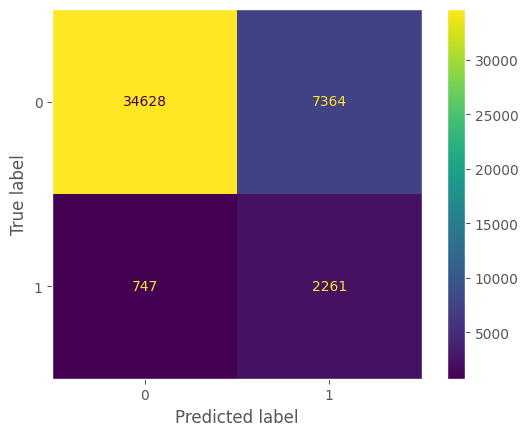

Precision: 0.235
Recall: 0.752


In [ ]:
y_pred_rf_cv_binary =  rf_cv.predict(X_val)
cm_rf = confusion_matrix(y_val, y_pred_rf_cv_binary, labels=rf_cv.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                              display_labels=rf_cv.classes_)
disp_rf.plot()
plt.grid(False)
plt.show()

print(f"Precision: {np.round(precision_score(y_val, y_pred_rf_cv_binary), 3)}\nRecall: {np.round(recall_score(y_val, y_pred_rf_cv_binary), 3)}")

Случайный лес показал существенное повышение precision и recall в сравнении с предыдущей моделью.

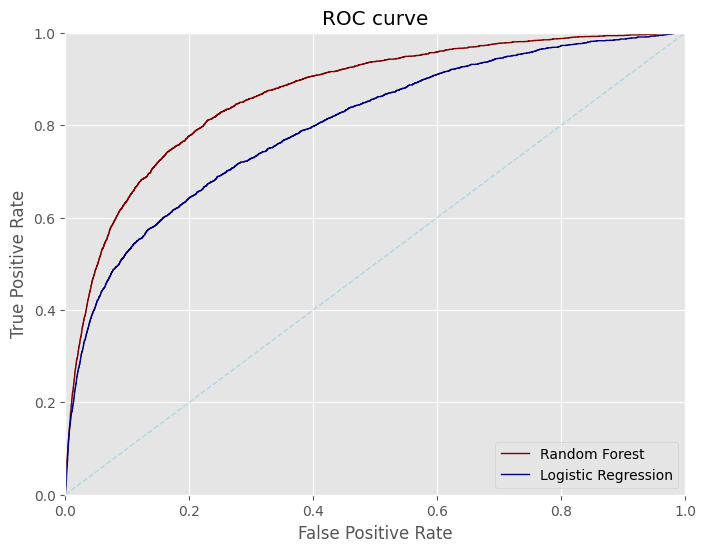

In [ ]:
fpr_2, tpr_2, _ = roc_curve(y_val, y_pred_rf_cv)

plt.figure(figsize=(8, 6))
plt.plot(fpr_2, tpr_2, color='maroon', lw=1, label='Random Forest')
plt.plot(fpr_1, tpr_1, color='navy', lw=1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], color='lightblue', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Целевая матрика ROC - AUC также значительно выше чем у логистической регрессии.

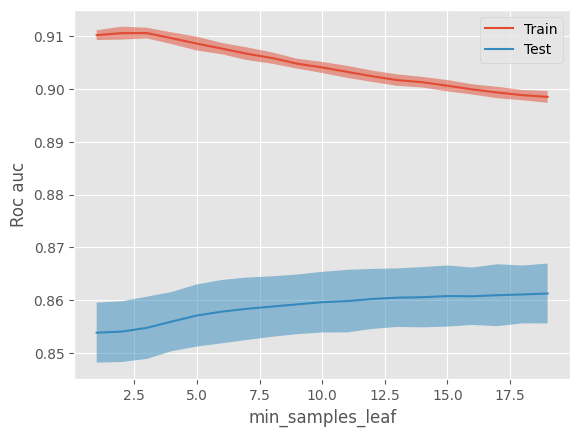

In [ ]:
ValidationCurveDisplay.from_estimator(rf_cv, X_train, y_train,
                                      param_name='min_samples_leaf',
                                      param_range=range(1, 20),
                                      cv=cv, scoring='roc_auc',
                                      n_jobs=8)

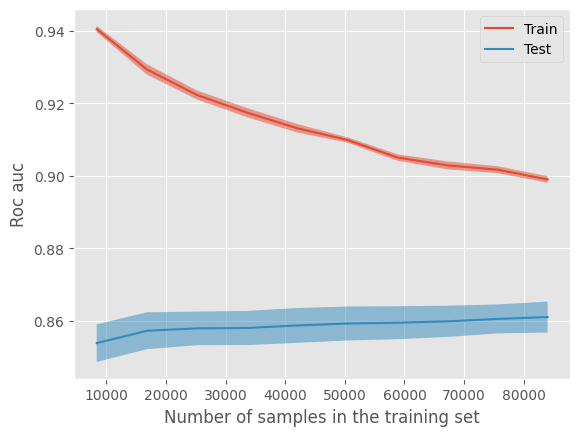

In [ ]:
LearningCurveDisplay.from_estimator(rf_cv, X_train, y_train,
                                    train_sizes=np.arange(0.1, 1.1, 0.1),
                                    cv=cv, scoring='roc_auc',
                                    n_jobs=8)

Судя по валидационной кривой, построенной по главному гиперпараметру (минимальное количество объектов для разбиения), значения метрики близки к выходу на плато, что говорит о достижении моделью оптимума с точки зрения ее сложности.  
Кривые на втором графике не успели сойтись, значит добавление обучающих данных скорее всего обеспечит модели небольшой прирост в качестве.  
  
Рассмотрим модель Градиентного Бустинга аналогично.

###**Градиентный бустинг**

In [ ]:
gb = XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=-1)
scores_gb_cv = cross_val_score(gb, X_train, y_train, cv=cv,
                               scoring='roc_auc')

print(f'Значения метрики модели на кросс-валидации: {scores_gb_cv} \nСреднее значение: {np.mean(scores_gb_cv)}')

Значения метрики модели на кросс-валидации: [0.84386182 0.83638966 0.8346318  0.83558011 0.83756647] 
Среднее значение: 0.8376059712098218


In [ ]:
gb.fit(X_train, y_train)
y_pred_gb = gb.predict_proba(X_val)[:, 1]
score_gb = roc_auc_score(y_val, y_pred_gb)
print(f'Значения метрики модели на валидационной выборке: {score_gb}')

Значения метрики модели на валидационной выборке: 0.8521683413988682


In [ ]:
def objective_gb(trial):
    params_gb = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5)
    }

    model_gb = XGBClassifier(**params_gb, scale_pos_weight=scale_pos_weight)

    score_gb = cross_val_score(model_gb, X_train, y_train, cv=cv,
                                scoring='roc_auc', n_jobs=8).mean()
    return score_gb

study_gb = optuna.create_study(study_name="xgboost_scoring_study", direction='maximize')
study_gb.optimize(objective_gb, n_trials=200, show_progress_bar=False, n_jobs=8)

[I 2025-12-20 14:32:51,754] A new study created in memory with name: xgboost_scoring_study
[I 2025-12-20 14:33:39,252] Trial 5 finished with value: 0.8631168517647808 and parameters: {'n_estimators': 394, 'learning_rate': 0.040211184077480006, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'subsample': 0.9350044917895546, 'colsample_bytree': 0.9294981034077454, 'min_child_weight': 1, 'gamma': 0.3130580994440696}. Best is trial 5 with value: 0.8631168517647808.
[I 2025-12-20 14:33:55,028] Trial 4 finished with value: 0.8382757559968423 and parameters: {'n_estimators': 317, 'learning_rate': 0.032518715506082894, 'max_depth': 19, 'min_samples_leaf': 12, 'min_samples_split': 12, 'subsample': 0.7773204616766926, 'colsample_bytree': 0.9993967915163872, 'min_child_weight': 4, 'gamma': 1.4644394637406655}. Best is trial 5 with value: 0.8631168517647808.
[I 2025-12-20 14:34:12,741] Trial 2 finished with value: 0.8571632734500513 and parameters: {'n_estimators': 623, 'learning_r

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

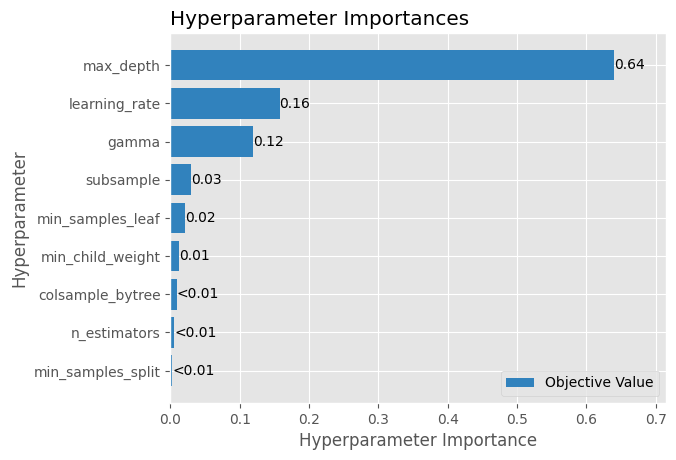

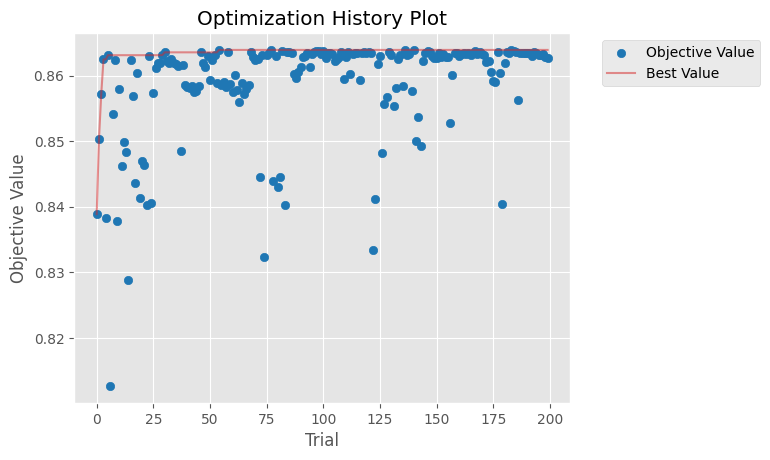

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study_gb)
optuna.visualization.matplotlib.plot_optimization_history(study_gb)

In [ ]:
gb_cv = XGBClassifier(**study_gb.best_params, scale_pos_weight=scale_pos_weight)
gb_cv.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5471987404671077
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
y_pred_gb_cv = gb_cv.predict_proba(X_val)[:, 1]
best_score_gb = roc_auc_score(y_val, y_pred_gb_cv)
print(f'Лучшие параметры: {study_gb.best_params}')
print(f'Значения метрики модели на валидационной выборке: {best_score_gb}')

Лучшие параметры: {'n_estimators': 536, 'learning_rate': 0.022885244094509084, 'max_depth': 4, 'min_samples_leaf': 12, 'min_samples_split': 16, 'subsample': 0.6396799399161368, 'colsample_bytree': 0.5471987404671077, 'min_child_weight': 5, 'gamma': 0.25812932987338855}
Значения метрики модели на валидационной выборке: 0.8699402604358784


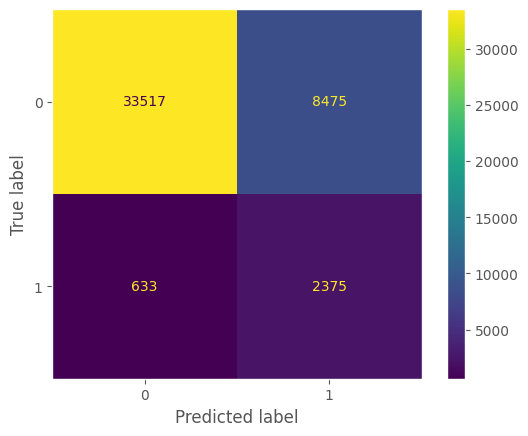

Precision: 0.219
Recall: 0.79


In [ ]:
y_pred_gb_cv_binary =  gb_cv.predict(X_val)
cm_gb = confusion_matrix(y_val, y_pred_gb_cv_binary, labels=gb_cv.classes_)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb,
                              display_labels=gb_cv.classes_)
disp_gb.plot()
plt.grid(False)
plt.show()

print(f"Precision: {np.round(precision_score(y_val, y_pred_gb_cv_binary), 3)}\nRecall: {np.round(recall_score(y_val, y_pred_gb_cv_binary), 3)}")

Для данной модели можем видеть схожее со случайным лесом значение precision и большее значение recall.

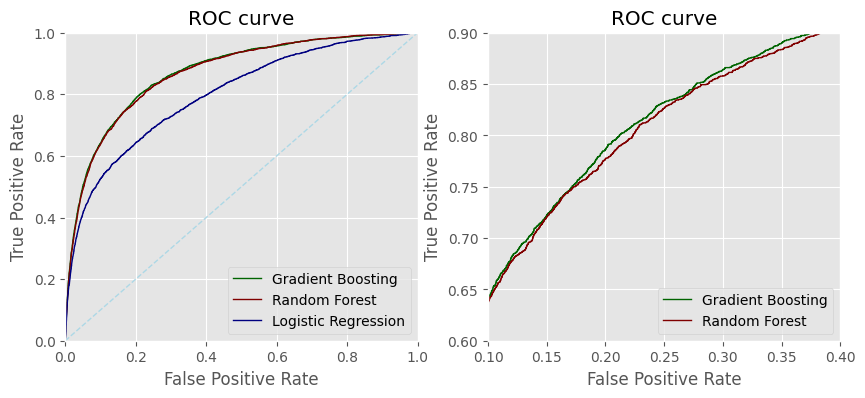

In [ ]:
fpr_3, tpr_3, _ = roc_curve(y_val, y_pred_gb_cv)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))


axes[0].plot(fpr_3, tpr_3, color='darkgreen', lw=1, label='Gradient Boosting')
axes[0].plot(fpr_2, tpr_2, color='maroon', lw=1, label='Random Forest')
axes[0].plot(fpr_1, tpr_1, color='navy', lw=1, label='Logistic Regression')
axes[0].plot([0, 1], [0, 1], color='lightblue', lw=1, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.0])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC curve')
axes[0].legend(loc="lower right")

axes[1].plot(fpr_3, tpr_3, color='darkgreen', lw=1, label='Gradient Boosting')
axes[1].plot(fpr_2, tpr_2, color='maroon', lw=1, label='Random Forest')
axes[1].set_xlim([0.1, 0.4])
axes[1].set_ylim([0.6, 0.9])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC curve')
axes[1].legend(loc="lower right")

plt.show()

ROC - AUC незначительно больше у модели градиентного бустинга.

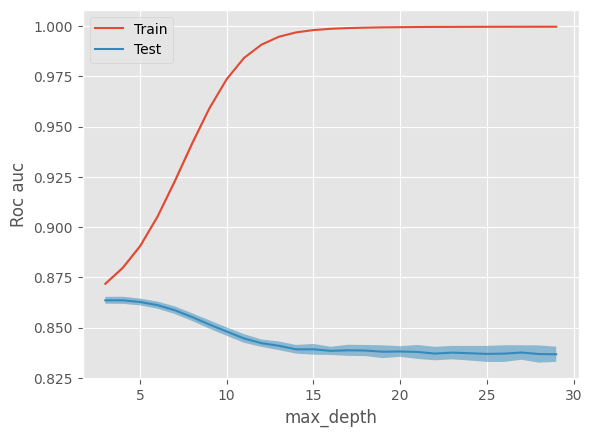

In [ ]:
ValidationCurveDisplay.from_estimator(gb_cv, X_train, y_train,
                                      param_name='max_depth',
                                      param_range=range(3, 20),
                                      cv=cv, scoring='roc_auc',
                                      n_jobs=-1)

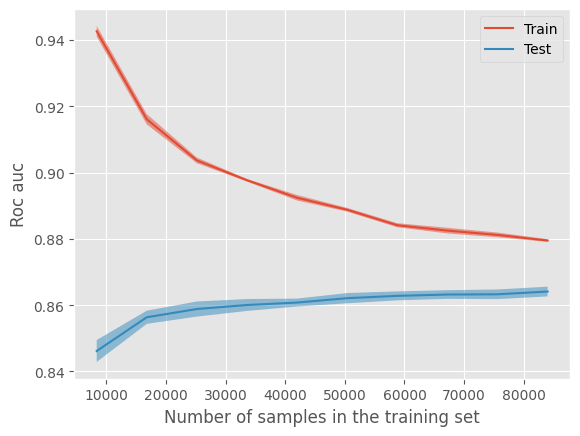

In [ ]:
LearningCurveDisplay.from_estimator(gb_cv, X_train, y_train,
                                    train_sizes=np.arange(0.1, 1.1, 0.1),
                                    cv=cv, scoring='roc_auc',
                                    n_jobs=-1)

Валидационная кривая по признаку max_depth (максимальная глубина дерева) показывает, что усложнение базовых алгоритмов ведет к переобучению, то есть снижению качества на валидационной выборке при улучшении на тренировочной.  
Кривая обучения же говорит о том, что увеличение количества данных в обучающей выборке способно увеличить качество модели, т.к. кривые еще не сошлись.

Построим PR - curve для выбора оптимального порога классификации:

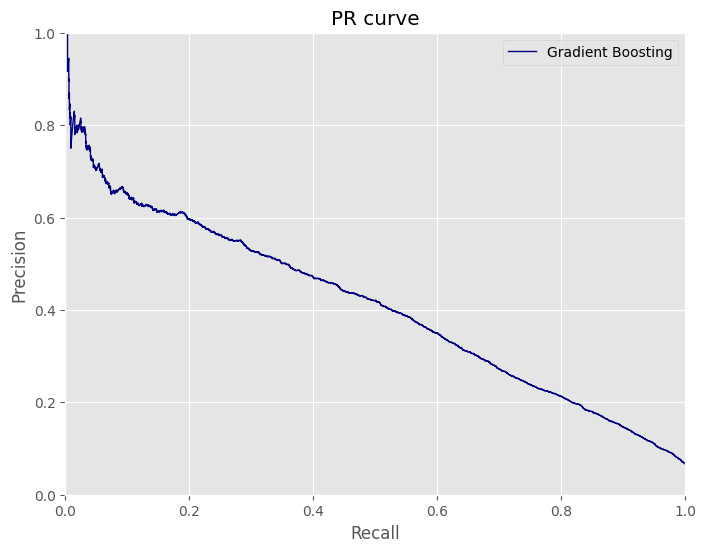

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_gb_cv)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='navy', lw=1, label='Gradient Boosting')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(loc="upper right")
plt.show()

Зададим значение precision, отталкиваясь от которого подберем оптимальный порог:

In [ ]:
target_precision = 0.6

target_idx = np.where(precision[:-1] >= target_precision)[0][0]

print(f'Значение порога классификации: {thresholds[target_idx]}')
print(f'Значения precision и recall: {precision[target_idx]}, {recall[target_idx]}')

Значение порога классификации: 0.9331651926040649
Значения precision и recall: 0.6, 0.19647606382978725


Проанализируем результаты для данного порога:

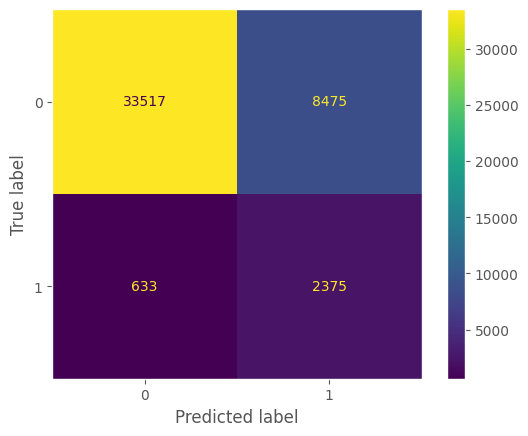

Precision: 0.6
Recall: 0.196


In [ ]:
y_pred_gb_cv_thresh =  (y_pred_gb_cv >= thresholds[target_idx]).astype(int)
cm_gb_thresh = confusion_matrix(y_val,y_pred_gb_cv_thresh, labels=gb_cv.classes_)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb,
                              display_labels=gb_cv.classes_)
disp_gb.plot()
plt.grid(False)
plt.show()

print(f"Precision: {np.round(precision_score(y_val, y_pred_gb_cv_thresh), 3)}\nRecall: {np.round(recall_score(y_val, y_pred_gb_cv_thresh), 3)}")

Модель с таким порогом будет допускать  пропуски, но при этом не будет отклонять слишком много потенциально безопасных заемщиков, что крайне важно для нашей задачи.  
  
Нужно учитывать, что в некоторых ситуациях цена ошибки второго рода может быть и выше, а значит настраивать порог классификации необходимо с учетом реальных потенциальных потерь и показателей.

##**Интерпретация важности признаков**

Оценим важности признаков с помощью методов каждой модели:

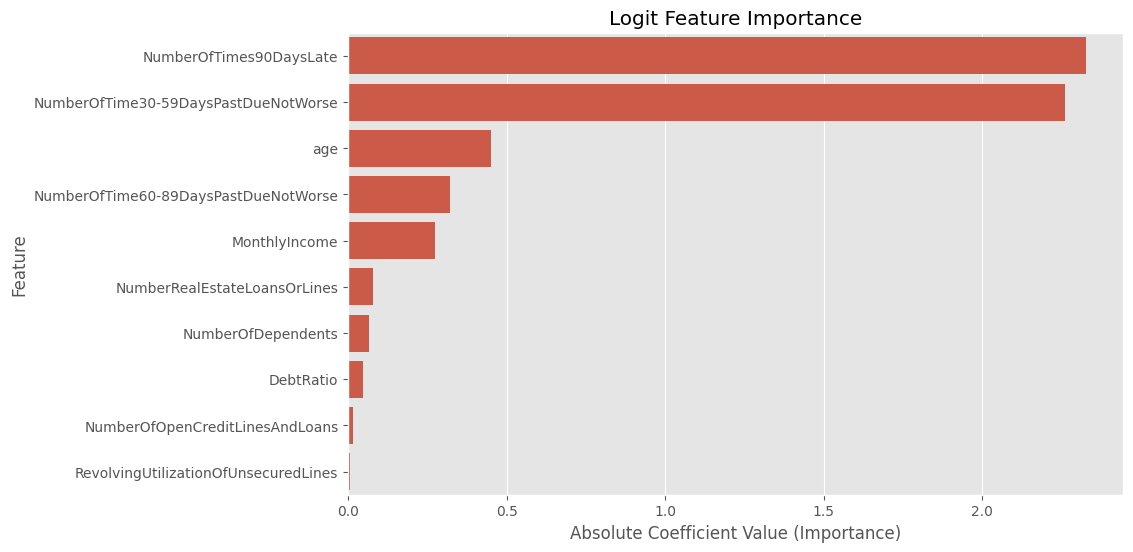

In [ ]:
feature_importance_df_logit = pd.DataFrame({'Feature': data_test.columns,
                                      'Importance': np.abs(logit.coef_[0])})
feature_importance_df_logit = feature_importance_df_logit.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_logit)
plt.title('Logit Feature Importance')
plt.xlabel('Absolute Coefficient Value (Importance)')
plt.ylabel('Feature')
plt.show()

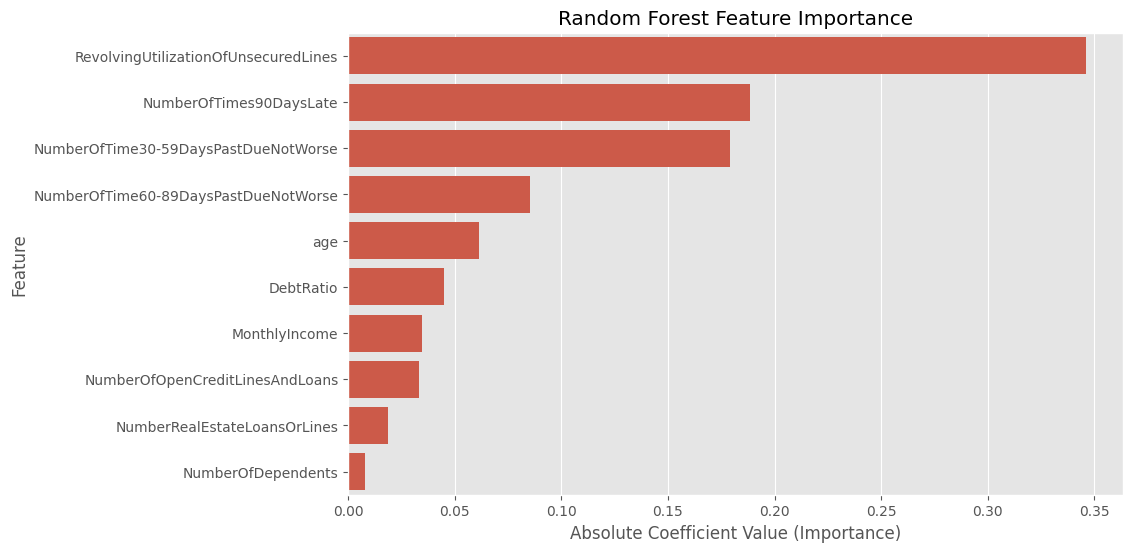

In [ ]:
feature_importance_df_rf = pd.DataFrame({'Feature': data_test.columns,
                                      'Importance': rf_cv.feature_importances_})

feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf)
plt.title('Random Forest Feature Importance')
plt.xlabel('Absolute Coefficient Value (Importance)')
plt.ylabel('Feature')
plt.show()

<Axes: title={'center': 'Gradient Boosting Feature importance'}, xlabel='Importance score', ylabel='Features'>

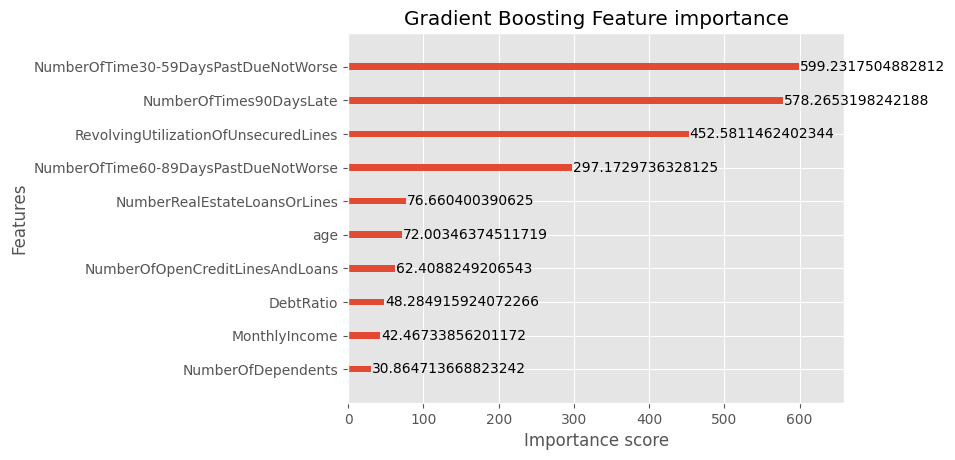

In [ ]:
feature_names = [f'{i}' for i in data_test.columns]
gb_cv.get_booster().feature_names = feature_names

plot_importance(gb_cv.get_booster(), importance_type='gain', title='Gradient Boosting Feature importance')

Итого, основную часть информации несут в себе признаки, связанные с предыдущими невыполнениями кредитных обязательств. Именно эти признаки мы выделили при анализе корреляций в данных.

##**Дальнейшие действия**

Чтобы улучшить результат модели, можно попробовать:  
  
1). Использовать другие модели, например KNN или нейросети (в случае нейросетей, возможно, придется пожертвовать интерпретируемостью);  
  
2). Создать новые признаки, преобразовать уже имеющиеся (например, преобразовать возраст в категориальный признак или объединить три признака, связанные с невыполнением кредитных обязательств);  
  
3). Не использовать малоинформативные признаки (к примеру, количество иждивенцев);  
  
4). Обработать выбросы из выборки;  
  
5). Оптимизировать модели по другой метрике (например, f-мера с коэффициентом в пользу precision или recall, в зависимости от конкретной задачи)